In [351]:
import astropy
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
from pathlib import Path
from glob import glob
import re
import logging
from rich.progress import Progress
import numpy as np
import sunpy
import pandas as pd
from datetime import datetime, date, timedelta
import sscws
from sunpy.net import Fido, attrs as a
from functools import reduce

In [5]:
fname_HAO = []#glob("fdl_space_weather_data/HAO_data/data_fits/*/*.fits")
fname_stereo = glob("ssa_live_twin_development_data/*/*.fts")

fnames = fname_HAO + fname_stereo
print(len(fnames))

1697


Output()

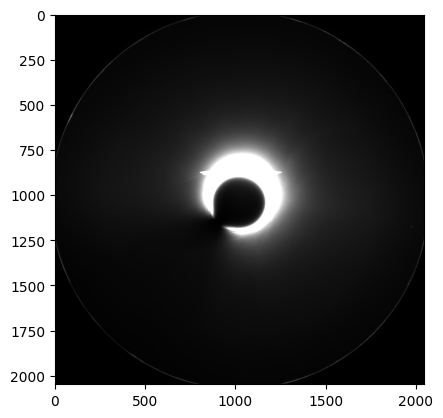

In [10]:
broken_files = []
with Progress() as progress:
    task = progress.add_task("Plotting Stereo Data", total = len(fnames))
    for fname in fnames:
        plt.close("all")
        path_components_fname = fname.split("/")[:-1]
        path_components = ["plots"]
        path_components = path_components + path_components_fname
        joined_path = os.path.join(*path_components)
        if not os.path.exists(joined_path):
            os.makedirs(joined_path)
        try:
            plotname = joined_path +"/beacon_substitute_"+ fname.split("/")[-1].split(".")[0]+".jpg"
            img_data = fits.getdata(fname)
            plt.imshow(img_data,cmap = "gray")
            plt.title("Beacon Substitute: "+fname.split("/")[-1].split(".")[0])
            plt.savefig(plotname)
        except Exception as e:
            logging.warning("Error: {} - File {}! Check manually".format(e,fname))
            broken_files.append(fname)
        progress.update(task,advance = 1)


In [11]:
fname_part =fname.split("/")[-1].split(".")[0]

In [25]:
png_name = 'plots/ssa_live_twin_development_data/cor2/secchi_l0_b_img_cor2_20120307_20120307_022400_d4c2b.png'

In [304]:
png_jpg_size_ratio = os.stat(png_name).st_size/os.stat(plotname).st_size 
# Irrelevant, going up against the ICER algorithm for beacon data...

## Set up Satellite Position Data

In [310]:
# Ephemeris Files for wanted objects
l5_positions_fname = "L5_positions_ephemeris.txt"
stereoA_positions_fname = "StereoA_positions_ephemeris.txt"
stereoB_positions_fname = "StereoB_positions_ephemeris.txt"
SOHO_positions_fname = "SOHO_positions_ephemeris.txt"

In [250]:
def load_ephemeris_data(fname:str) -> list:
    '''
        Loads data from horizon ephemeris files, passed as argument.
    '''
    with open(fname) as f:
        data = f.readlines()

    start_position = 0
    end_position = 0
    for i, line in enumerate(data):
        if "$$SOE" in line:
            start_position = i + 1
        if "$$EOE" in line:
            end_position = i
            
    return data[start_position:end_position]

In [311]:
l5_positions_data = load_ephemeris_data(l5_positions_fname)
stereoA_positions_data = load_ephemeris_data(stereoA_positions_fname)
stereoB_positions_data = load_ephemeris_data(stereoB_positions_fname)
SOHO_positions_data = load_ephemeris_data(SOHO_positions_fname)

In [312]:


def data_to_vectors(data,Time:list = None):
    '''
        Takes the data returned by the load_data function and turns it into the required vectors
    '''
    time = Time if Time is not None else []
    x = []
    y = []
    z = []
    r = []
    
    for line in data:
        t,p = line.strip("\n").split("     ")
        t2 = t.split(" ")[1] + " " + t.split(" ")[2]
        if Time is not None:
            assert datetime.strptime(sa_time2,"%Y-%b-%d %H:%M") in Time,"New Time found in line {}".format(line)
        else:
            time.append(datetime.strptime(t2,"%Y-%b-%d %H:%M"))
        space_split = [i for i in p.split(" ") if i != ""]
        RA = float(space_split[0])*np.pi/180 # Radian for numpy
        DEC = float(space_split[1])*np.pi/180 # Radian for numpy
        
        cr = float(space_split[2]) # in km
        #dont use rdot here
        cx = cr*np.cos(DEC)*np.cos(RA*np.cos(DEC)) # km
        cy = cr*np.cos(DEC)*np.sin(RA*np.cos(DEC)) # km
        cz = cr*np.sin(DEC) # km
        
        x.append(cx)
        y.append(cy)
        z.append(cz)
        r.append(cr)
    return time, x,y,z,r
        
Time,L5x,L5y,L5z,L5r = data_to_vectors(l5_positions_data)
_,SAx,SAy,SAz,SAr = data_to_vectors(stereoA_positions_data,Time)
_,SBx,SBy,SBz,SBr = data_to_vectors(stereoB_positions_data,Time)
_,Sohox,Sohoy,Sohoz,Sohor = data_to_vectors(SOHO_positions_data, Time)


In [313]:
initial_colnames = ["L5 x [km]","L5 y [km]","L5 z [km]","L5 r [km]","SA x [km]","SA y [km]","SA z [km]","SA r [km]","SB x [km]","SB y [km]","SB z [km]","SB r [km]", "SOHO x [km]","SOHO y [km]","SOHO z [km]", "SOHO r [km]"]
initial_data = (np.asarray([L5x,L5y,L5z,L5r,SAx,SAy,SAz,SAr,SBx,SBy,SBz,SBr,Sohox,Sohoy,Sohoz,Sohor])).T

df = pd.DataFrame(initial_data,index = Time, columns = initial_colnames)
df.head()
df["Distance L5 Stereo A [km]"] = np.sqrt((df["L5 x [km]"] - df["SA x [km]"])**2+(df["L5 y [km]"] - df["SA y [km]"])**2+(df["L5 z [km]"] - df["SA z [km]"])**2)
df["Distance L5 Stereo B [km]"] = np.sqrt((df["L5 x [km]"] - df["SB x [km]"])**2+(df["L5 y [km]"] - df["SB y [km]"])**2+(df["L5 z [km]"] - df["SB z [km]"])**2)                                           
df["Stereo AB Angle [deg]"] = np.arccos((df["SA x [km]"]*df["SB x [km]"]+df["SA y [km]"]*df["SB y [km]"]+df["SA z [km]"]*df["SB z [km]"])/(df["SA r [km]"]*df["SB r [km]"]))*180/np.pi                                          
df["Stereo A Soho Angle [deg]"] = np.arccos((df["SA x [km]"]*df["SOHO x [km]"]+df["SA y [km]"]*df["SOHO y [km]"]+df["SA z [km]"]*df["SOHO z [km]"])/(df["SA r [km]"]*df["SOHO r [km]"]))*180/np.pi                          
df["Stereo B Soho Angle [deg]"] = np.arccos((df["SB x [km]"]*df["SOHO x [km]"]+df["SB y [km]"]*df["SOHO y [km]"]+df["SB z [km]"]*df["SOHO z [km]"])/(df["SB r [km]"]*df["SOHO r [km]"]))*180/np.pi                                              

# Statistics
df.describe()
                                          

,L5 x [km],L5 y [km],L5 z [km],L5 r [km],SA x [km],SA y [km],SA z [km],SA r [km],SB x [km],SB y [km],...,SB r [km],SOHO x [km],SOHO y [km],SOHO z [km],SOHO r [km],Distance L5 Stereo A [km],Distance L5 Stereo B [km],Stereo AB Angle [deg],Stereo A Soho Angle [deg],Stereo B Soho Angle [deg]
count,6.133000e+03,6.133000e+03,6.133000e+03,6.133000e+03,6.133000e+03,6.133000e+03,6.133000e+03,6.133000e+03,6.133000e+03,6.133000e+03,...,6.133000e+03,6.133000e+03,6.133000e+03,6.133000e+03,6.133000e+03,6.133000e+03,6.133000e+03,6133.000000,6133.000000,6133.000000
mean,-1.093853e+07,9.249593e+05,-4.022972e+05,1.496106e+08,-9.196883e+06,2.677289e+06,4.660225e+05,1.439389e+08,-6.272950e+06,-5.827371e+06,...,1.560251e+08,-8.932066e+06,-1.626275e+06,-1.414962e+06,1.481767e+08,1.854047e+08,1.927254e+08,88.315870,88.915650,87.483529
std,1.060671e+08,9.622362e+07,4.195500e+07,1.773934e+06,1.012193e+08,9.351544e+07,4.049445e+07,6.939306e+05,1.099443e+08,1.010877e+08,...,4.677574e+06,1.042752e+08,9.619759e+07,4.184847e+07,1.764040e+06,9.076055e+07,9.357822e+07,53.609661,52.821383,53.798662
min,-1.514174e+08,-1.396734e+08,-6.017884e+07,1.470926e+08,-1.445189e+08,-1.330234e+08,-5.677212e+07,1.430467e+08,-1.524153e+08,-1.506150e+08,...,1.462968e+08,-1.477683e+08,-1.399895e+08,-5.992384e+07,1.454568e+08,5.923984e+06,1.290117e+07,0.000037,0.019359,0.020236
25%,-1.153113e+08,-9.219724e+07,-4.227661e+07,1.478339e+08,-1.085343e+08,-8.851677e+07,-4.021653e+07,1.433148e+08,-1.147049e+08,-1.032355e+08,...,1.514207e+08,-1.113734e+08,-9.514334e+07,-4.350318e+07,1.464211e+08,1.087704e+08,1.154961e+08,42.040884,41.790006,39.400313
50%,-2.226363e+07,-4.203599e+05,-1.821558e+05,1.496196e+08,-1.924125e+07,1.540485e+06,6.722272e+05,1.439145e+08,-1.733488e+07,-9.812866e+06,...,1.561582e+08,-1.965459e+07,-4.183600e+06,-1.848955e+06,1.482094e+08,2.063234e+08,2.095811e+08,87.391940,90.595187,86.881158
75%,9.560303e+07,9.828928e+07,4.145216e+07,1.513940e+08,9.131822e+07,9.772570e+07,4.114301e+07,1.445005e+08,1.025505e+08,9.674761e+07,...,1.606854e+08,9.455198e+07,9.619815e+07,4.058237e+07,1.499355e+08,2.732687e+08,2.810017e+08,135.377386,137.467764,133.353231
max,1.477674e+08,1.362064e+08,5.882220e+07,1.521006e+08,1.434260e+08,1.342996e+08,5.821212e+07,1.485056e+08,1.595281e+08,1.378418e+08,...,1.625370e+08,1.488779e+08,1.340513e+08,5.812945e+07,1.508172e+08,2.957591e+08,3.102140e+08,179.786032,179.423029,178.296012


### Create Plots from dataframe

In [319]:
# Parameters
earth_l5_angle_degrees = 60
error_range_degrees = 5
required_distance_to_l5_km = 50000000 #km
max_angle_between_crafts_deg = earth_l5_angle_degrees + error_range_degrees
min_angle_between_crafts_deg = earth_l5_angle_degrees - error_range_degrees

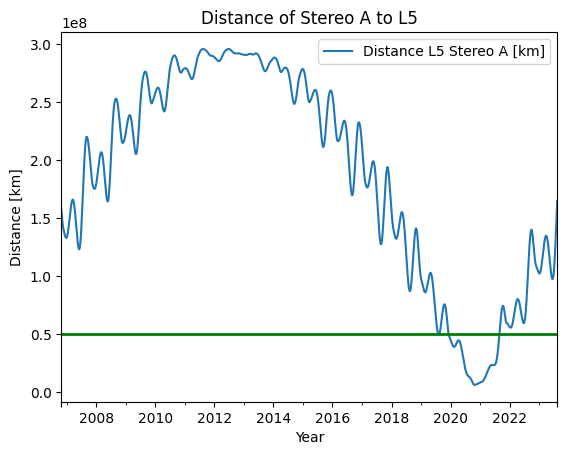

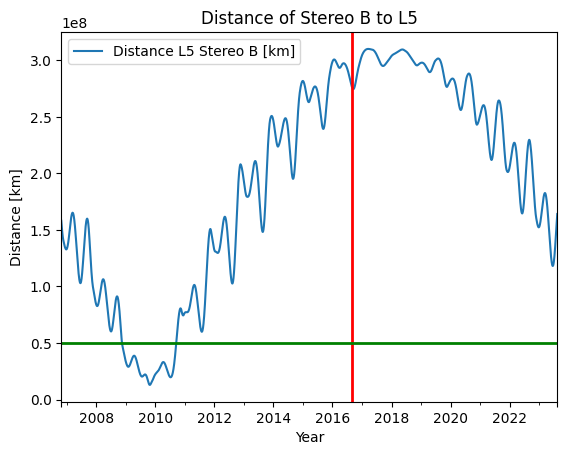

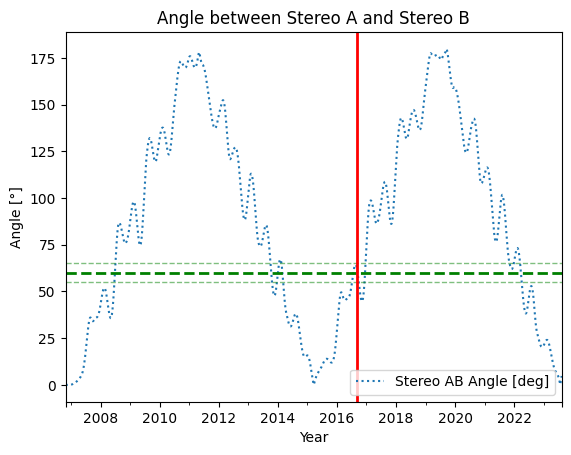

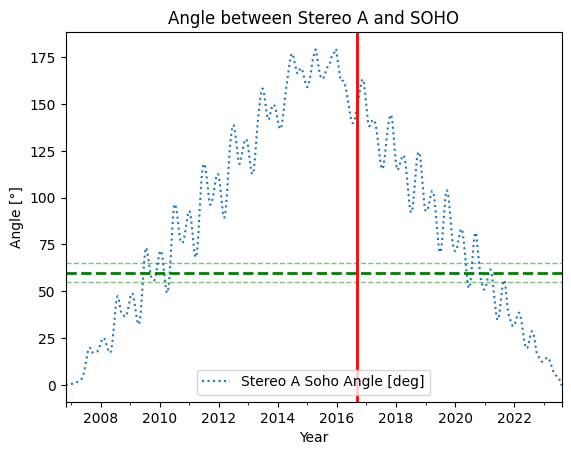

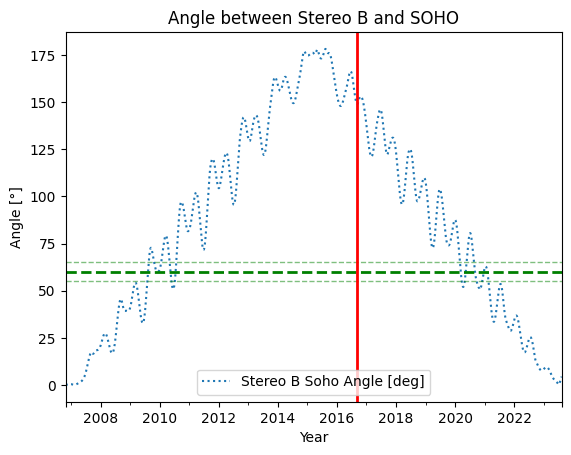

In [320]:


approx_date_last_B_contact = date(2016,9,1) #some time September 2016

ax = df.plot(title = "Distance of Stereo A to L5", xlabel = "Year", ylabel = "Distance [km]", y = "Distance L5 Stereo A [km]")
ax.axhline(y = required_distance_to_l5_km, linestyle = "-", color = "g", linewidth = 2)
plt.savefig("dist_a_l5.png")

ax = df.plot(title = "Distance of Stereo B to L5", xlabel = "Year", ylabel = "Distance [km]",y = "Distance L5 Stereo B [km]")
ax.axvline(x = approx_date_last_B_contact, linestyle = "-", color = "r", linewidth = 2)
ax.axhline(y = required_distance_to_l5_km, linestyle = "-", color = "g", linewidth = 2)
plt.savefig("dist_b_l5.png")


ax = df.plot(title = "Angle between Stereo A and Stereo B",xlabel = "Year", ylabel = "Angle [°]", y = "Stereo AB Angle [deg]",linestyle = ":")
ax.axhline(y = earth_l5_angle_degrees,linestyle = "--", color = "g", linewidth = 2)
ax.axhline(y = earth_l5_angle_degrees + error_range_degrees,linestyle = "--", color = "g", linewidth = 1, alpha = 0.5)
ax.axhline(y = earth_l5_angle_degrees - error_range_degrees,linestyle = "--", color = "g", linewidth = 1, alpha = 0.5)
ax.axvline(x = approx_date_last_B_contact, linestyle = "-", color = "r", linewidth = 2) 
plt.savefig("Angle_AB.png")

ax = df.plot(title = "Angle between Stereo A and SOHO",xlabel = "Year", ylabel = "Angle [°]", y = "Stereo A Soho Angle [deg]",linestyle = ":")
ax.axhline(y = earth_l5_angle_degrees,linestyle = "--", color = "g", linewidth = 2)
ax.axhline(y = earth_l5_angle_degrees + error_range_degrees,linestyle = "--", color = "g", linewidth = 1, alpha = 0.5)
ax.axhline(y = earth_l5_angle_degrees - error_range_degrees,linestyle = "--", color = "g", linewidth = 1, alpha = 0.5)
ax.axvline(x = approx_date_last_B_contact, linestyle = "-", color = "r", linewidth = 2) 
plt.savefig("Angle_ASOHO.png")

ax = df.plot(title = "Angle between Stereo B and SOHO",xlabel = "Year", ylabel = "Angle [°]", y = "Stereo B Soho Angle [deg]",linestyle = ":")
ax.axhline(y = earth_l5_angle_degrees,linestyle = "--", color = "g", linewidth = 2)
ax.axhline(y = earth_l5_angle_degrees + error_range_degrees,linestyle = "--", color = "g", linewidth = 1, alpha = 0.5)
ax.axhline(y = earth_l5_angle_degrees - error_range_degrees,linestyle = "--", color = "g", linewidth = 1, alpha = 0.5)
ax.axvline(x = approx_date_last_B_contact, linestyle = "-", color = "r", linewidth = 2) 
plt.savefig("Angle_BSOHO.png")



# Discover relevant periods based on data and L5 proximity

In [346]:
# use query
df_angles_fit = df.query("`Stereo AB Angle [deg]` >= {} & `Stereo AB Angle [deg]` <= {}".format(min_angle_between_crafts_deg,max_angle_between_crafts_deg))
df_angles_perfect_fit = df.query("`Stereo AB Angle [deg]`== {}".format(earth_l5_angle_degrees))
df_stereoA_angles_fit = df.query("`Stereo A Soho Angle [deg]` >= {} & `Stereo A Soho Angle [deg]` <= {}".format(min_angle_between_crafts_deg,max_angle_between_crafts_deg))
df_stereoB_angles_fit = df.query("`Stereo B Soho Angle [deg]` >= {} & `Stereo B Soho Angle [deg]` <= {}".format(min_angle_between_crafts_deg,max_angle_between_crafts_deg))

df_StereoB_close = df.query("`Distance L5 Stereo B [km]` <= {}".format(required_distance_to_l5_km))
df_StereoA_close = df.query("`Distance L5 Stereo A [km]` <= {}".format(required_distance_to_l5_km))

# get times from df_{}.index
# Main point: Do angles fit? - more important than distance for now.
angle_AB_index = df_angles_fit.index
angle_ASOHO_index = df_stereoA_angles_fit.index
angle_BSOHO_index = df_stereoB_angles_fit.index
# Overlap?
overlap_ABASOHO = np.intersect1d(angle_AB_index,angle_ASOHO_index) #empty
overlap_ABBSOHO = np.intersect1d(angle_AB_index,angle_BSOHO_index) #empty
overlap_ASOHOBSOHO = np.intersect1d(angle_ASOHO_index,angle_BSOHO_index) 
# 24% of times, both angles A-SUN-SOHO, B-SUN-SOHO are within 55 to 65 degrees
# AB and Soho are never in a 60° pairing - ie no scenario of 60° on both angles between A,B and SOHO from either one
# in other words, never happens when either A, B are close to earth
union_index = reduce(np.union1d,(angle_AB_index, angle_ASOHO_index, angle_BSOHO_index))
#Need to recover consecutive groups - ie, each group only consists of elements that are no more than 1 day removed from each other.
time_differences = union_index[1:] - union_index[:-1]

In [370]:
endpoints = [-1,len(union_index)]
for time_diff_jumps_idx,td in enumerate(time_differences):
    if td != 86400000000000: # = 1 day in ns
        endpoints.append(time_diff_jumps_idx)
endpoints = np.sort(endpoints)
#print(endpoints)
timeseries_batches = [union_index[endpoints[i-1]+1:endpoints[i]] for i in range(1,len(endpoints))] 

# Query Data from FIDO

In [526]:
event_type = "CE"
# Can download SECCHI data with help from FIDO
event_batches = []
instrument_batches = []
for batch in timeseries_batches:
    min_time = np.min(batch)
    max_time = np.max(batch)
    time_requested_for_batch = a.Time(str(min_time),str(max_time))
    resulting_events_for_batch = Fido.search(time_requested_for_batch, a.hek.EventType(event_type))
    resulting_images_for_batch = Fido.search(time_requested_for_batch, a.Instrument("SECCHI"), a.Detector("COR1"))
    instrument_batches.append(resulting_images_for_batch)
    event_batches.append(resulting_events_for_batch)
'''
for batch in timeseries_batches:
    min_time = np.min(batch)
    max_time = np.max(batch)
    time_requested_for_batch = a.Time(str(min_time),str(max_time))
    resulting_events_for_batch = Fido.search(time_requested_for_batch, a.hek.EventType(event_type))
    resulting_images_for_batch = Fido.search(time_requested_for_batch, a.Instrument.secchi, a.Level.one)
    instrument_batches.append(resulting_images_for_batch)
    event_batches.append(resulting_events_for_batch)
'''

#a.Level restricts query to 0 images, regardless of Level set - unsure which level the image data is from


'\nfor batch in timeseries_batches:\n    min_time = np.min(batch)\n    max_time = np.max(batch)\n    time_requested_for_batch = a.Time(str(min_time),str(max_time))\n    resulting_events_for_batch = Fido.search(time_requested_for_batch, a.hek.EventType(event_type))\n    resulting_images_for_batch = Fido.search(time_requested_for_batch, a.Instrument.secchi, a.Level.one)\n    instrument_batches.append(resulting_images_for_batch)\n    event_batches.append(resulting_events_for_batch)\n'

In [527]:
instrument_batches

 Results from 1 Provider:
 
 4000 Results from the VSOClient:
 Source: http://vso.stanford.edu/cgi-bin/search
 Total estimated size: 8.479 Gbyte
 
        Start Time               End Time         Source  ... Extent Type   Size 
                                                          ...              Mibyte
 ----------------------- ----------------------- -------- ... ----------- -------
 2008-06-21 00:05:00.000 2008-06-21 00:05:01.000 STEREO_A ...      CORONA 2.02148
 2008-06-21 00:05:09.000 2008-06-21 00:05:10.000 STEREO_A ...      CORONA 2.02148
 2008-06-21 00:05:18.000 2008-06-21 00:05:19.000 STEREO_A ...      CORONA 2.02148
 2008-06-21 00:05:53.000 2008-06-21 00:05:55.000 STEREO_B ...      CORONA 2.02148
 2008-06-21 00:05:53.000 2008-06-21 00:05:55.000 STEREO_B ...      CORONA 2.02148
 2008-06-21 00:06:02.000 2008-06-21 00:06:04.000 STEREO_B ...      CORONA 2.02148
 2008-06-21 00:06:02.000 2008-06-21 00:06:04.000 STEREO_B ...      CORONA 2.02148
 2008-06-21 00:06:11.000 2008-06-

In [387]:
for i in range(len(event_batches)):
    t_batch = timeseries_batches[i]
    min_time = np.min(t_batch)
    max_time = np.max(t_batch)
    n_events = len(event_batches[i]["hek"])
    print("Between {} and {}, there have been {} events logged.".format(min_time, max_time, n_events))

Between 2008-06-21T00:00:00.000000000 and 2008-07-02T00:00:00.000000000, there have been 28 events logged.
Between 2009-06-07T00:00:00.000000000 and 2009-06-21T00:00:00.000000000, there have been 0 events logged.
Between 2009-08-01T00:00:00.000000000 and 2009-08-17T00:00:00.000000000, there have been 6 events logged.
Between 2009-08-21T00:00:00.000000000 and 2010-01-19T00:00:00.000000000, there have been 53 events logged.
Between 2010-02-13T00:00:00.000000000 and 2010-03-08T00:00:00.000000000, there have been 75 events logged.
Between 2010-04-28T00:00:00.000000000 and 2010-05-25T00:00:00.000000000, there have been 82 events logged.
Between 2010-07-08T00:00:00.000000000 and 2010-07-24T00:00:00.000000000, there have been 55 events logged.
Between 2013-10-03T00:00:00.000000000 and 2013-10-20T00:00:00.000000000, there have been 213 events logged.
Between 2013-12-21T00:00:00.000000000 and 2014-01-15T00:00:00.000000000, there have been 252 events logged.
Between 2014-02-16T00:00:00.000000000

gs_thumburl,comment_count,hpc_bbox,frm_humanflag,hgc_coord,event_coordsys,obs_levelnum,hpc_coord,event_npixels,gs_imageurl,ar_polarity,frm_paramset,hrc_coord,event_starttime,ar_mtwilsoncls,event_type,intensmin,obs_meanwavel,frm_url,bound_chaincode,noposition,active,intensmax,cme_accel,frm_versionnumber,area_uncert,obs_dataprepurl,hpc_geom,hgc_bbox,intensmedian,chaincodetype,obs_channelid,event_clippedspatial,ar_noaaclass,event_avg_rating,eventtype,intensunit,hpc_boundcc,event_mapurl,frm_contact,cme_accelunit,ar_penumbracls,intensmean,bound_ccstartc1,frm_name,area_atdiskcenter,frm_identifier,obs_observatory,event_description,boundbox_c2ur,obs_firstprocessingdate,boundbox_c2ll,frm_institute,hrc_bbox,refs_orig,ar_mcintoshcls,event_maskurl,bound_ccstartc2,gs_movieurl,event_score,cme_acceluncert,event_expires,hrc_boundcc,event_probability,intensvar,frm_daterun,event_coordunit,cme_angularwidth,hpc_y,hpc_x,search_instrument,ar_numspots,kb_archivdate,kb_archivist,intenstotal,sum_overlap_scores,hgs_boundcc,intensskew,obs_includesnrt,cme_angularwidthunit,rasterscan,obs_wavelunit,cme_radiallinvelstddev,kb_archivid,search_frm_name,boundbox_c1ur,ar_noaanum,area_atdiskcenteruncert,boundbox_c1ll,event_importance_num_ratings,ar_compactnesscls,cme_massuncert,event_testflag,event_c2error,cme_mass,hrc_r,obs_title,hcr_checked,frm_specificid,event_title,cme_massunit,obs_instrument,event_c1error,revision,hpc_radius,event_endtime,event_importance,event_coord2,event_coord3,event_coord1,search_observatory,cme_radiallinvelunit,area_raw,concept,event_pixelunit,hgc_boundcc,hrc_a,gs_galleryid,hgs_coord,ar_zurichcls,bound_ccnsteps,intenskurt,event_clippedtemporal,cme_radiallinvelmax,cme_radiallinveluncert,rasterscantype,search_channelid,hgs_bbox,area_unit,cme_radiallinvelmin,cme_radiallinvel,obs_lastprocessingdate,refs
str1,str1,str144,str5,str1,str12,object,str42,object,str1,object,str28,str12,Time,str1,str2,object,float64,str21,str1,str5,str4,object,object,float64,object,str1,str1,str1,object,str1,str33,str1,str1,object,str1,str1,str1,str1,str14,str1,str1,object,object,str36,object,str6,str5,str1,int64,str1,int64,str35,str42,str1,str1,str1,object,str1,str21,object,str1,str1,object,object,str19,str9,int64,float64,float64,str5,object,str19,str13,object,str1,str1,object,str1,str3,str1,str2,int64,str87,str6,int64,object,object,int64,str1,str1,object,str5,float64,object,int64,str1,str5,str1,str1,str1,str5,int64,str2,str19,Time,object,int64,object,int64,str5,str6,object,str3,str1,str1,int64,str1,str1,str1,object,object,str1,int64,float64,str1,str5,str1,str1,int64,int64,str1,object[4]
,0,"POLYGON((-1050.171332 1617.12204,-1363.441146 -1363.441146,-20451.617188 -20451.617188,-15752.569974 24256.830593,-1050.171332 1617.12204))",false,,UTC-HRC-TOPO,None,POINT(-1917.63409530254 201.55146510616),None,,None,thresh=0.30 factor=6 width=5,POINT(2 84),2022-03-16 11:24:07.000,,CE,None,6e-05,http://sidc.be/cactus,,false,true,None,None,2.5,None,,,,None,,"C2 orange filter, C3 clear filter",,,None,3,,,,cactus@sidc.be,,,None,None,CACTus (Computer Aided CME Tracking),None,CACTus,LASCO,,30,,2,Royal Observatory of Belgium - SIDC,"POLYGON((2 33,2 135,30 135,30 33,2 33))",,,,None,,0.182042427232363108,None,,,None,None,2022-03-30T02:20:58,"deg, rsun",102,201.55146510616,-1917.63409530254,LASCO,None,2022-03-30T02:30:52,robbrecht_eva,None,0,,None,,deg,,cm,110,ivo://helio-informatics.org/CE_CACTus(ComputerAidedCMETracking)_20220318_043610_8241.52,CACTus,135,None,None,33,,,None,false,0.6366639733314514,None,2,,false,,,,c2 c3,2,5,1928.19695999999999,2022-03-16 19:12:07.000,None,2,None,84,LASCO,km/sec,None,CME,,,84,,,,None,None,,694,36.900001525878906,,"C2,C3",,,130,369,,"{'ref_name': 'Details of event', 'ref_type': 'html', 'ref_url': 'http://sidc.oma.be/cactus/out/CME0055/CME.html'} .. {'ref_name': 'FRM_URL', 'ref_type': 'unknown', 'ref_url': 'http://sidc.be/cactus'}"
,0,"POLYGON((1314.971745 -1410.134554,1843.866214 563.726474,27657.993209 8455.897112,19724.576181 -21152.018315,1314.97

In [421]:
from sscws import sscws

In [422]:
sscws = sscws.SscWs()

In [458]:
time = ["2022/06/01","2023/07/13"]
locations = sscws.get_locations(["soho","sun","stereoa","stereob"], time)

In [459]:
soho_triple = [locations["Data"][0]["Coordinates"][0]["X"],locations["Data"][0]["Coordinates"][0]["Y"],locations["Data"][0]["Coordinates"][0]["Z"]]
sun_triple = [locations["Data"][1]["Coordinates"][0]["X"],locations["Data"][1]["Coordinates"][0]["Y"],locations["Data"][1]["Coordinates"][0]["Z"]]
stereoa_triple = [locations["Data"][2]["Coordinates"][0]["X"],locations["Data"][2]["Coordinates"][0]["Y"],locations["Data"][2]["Coordinates"][0]["Z"]]
stereob_triple = [locations["Data"][3]["Coordinates"][0]["X"],locations["Data"][3]["Coordinates"][0]["Y"],locations["Data"][3]["Coordinates"][0]["Z"]]


In [460]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


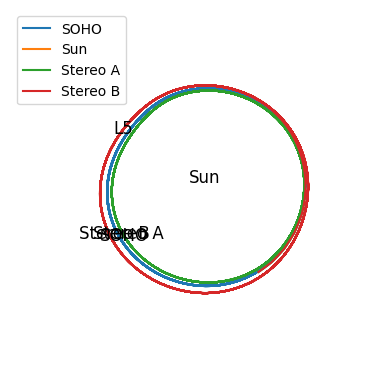

In [518]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90, azim=0) 

sohox,sohoy,sohoz = [df["SOHO x [km]"],df["SOHO y [km]"],df["SOHO z [km]"]]
sunx,suny,sunz = [np.zeros_like(sohox),np.zeros_like(sohox),np.zeros_like(sohox)] #didnt query data, assume 0
stereoax,stereoay,stereoaz = [df["SA x [km]"],df["SA y [km]"],df["SA z [km]"]]
stereobx,stereoby,stereobz = [df["SB x [km]"],df["SB y [km]"],df["SB z [km]"]]

#sohoz = np.zeros_like(stereoax)
#sunz = np.zeros_like(sunx)
#stereoaz = np.zeros_like(stereoax)
#stereobz = np.zeros_like(stereobx)

ax.plot(sohox,sohoy,sohoz, label = "SOHO")
ax.plot(sunx,suny,sunz, label = "Sun")
ax.plot(stereoax,stereoay,stereoaz, label = "Stereo A")
ax.plot(stereobx,stereoby,stereobz, label = "Stereo B")

l_sohox = sohox[-1]
l_sohoy = sohoy[-1]
l_sohoz = sohoz[-1]
l_sunx = sunx[-1]
l_suny = suny[-1]
l_sunz = sunz[-1]
l_stereoax = stereoax[-1]
l_stereoay = stereoay[-1]
l_stereoaz = stereoaz[-1]
l_stereobx = stereobx[-1]
l_stereoby = stereoby[-1]
l_stereobz = stereobz[-1]

l5_pos = [df["L5 x [km]"][-1],df["L5 y [km]"][-1],df["L5 z [km]"][-1]]

ax.text(l_sohox,l_sohoy,l_sohoz, 'SOHO', fontsize=12, ha='center', va='bottom')
ax.text(l_sunx,l_suny,l_sunz, 'Sun', fontsize=12, ha='center', va='bottom')
ax.text(l_stereoax,l_stereoay,l_stereoaz, 'Stereo A', fontsize=12, ha='center', va='bottom')
ax.text(l_stereobx,l_stereoby,l_stereobz, 'Stereo B', fontsize=12, ha='center', va='bottom')
ax.text(*l5_pos, "L5",fontsize = 12, ha = "center",va = "bottom")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
ax.axis("off")
plt.savefig("soho_sun_l5_stereo.png")

-46282090.87291293

In [503]:
df.tail()

,L5 x [km],L5 y [km],L5 z [km],L5 r [km],SA x [km],SA y [km],SA z [km],SA r [km],SB x [km],SB y [km],...,SB r [km],SOHO x [km],SOHO y [km],SOHO z [km],SOHO r [km],Distance L5 Stereo A [km],Distance L5 Stereo B [km],Stereo AB Angle [deg],Stereo A Soho Angle [deg],Stereo B Soho Angle [deg]
2023-08-07,-8.359138e+07,-1.125714e+08,-5.799338e+07,151733518.3,7.384774e+07,-1.156372e+08,-4.109802e+07,143228835.1,7.449498e+07,-1.353439e+08,...,162058706.1,7.793545e+07,-1.210243e+08,-4.325236e+07,150304951.1,1.583727e+08,1.599743e+08,3.681025,0.213799,3.870885
2023-08-08,-8.200478e+07,-1.135683e+08,-5.825584e+07,151711176.9,7.694630e+07,-1.138636e+08,-4.037203e+07,143232531.8,7.744026e+07,-1.338952e+08,...,162041227.8,8.087099e+07,-1.192978e+08,-4.255069e+07,150275241.1,1.599543e+08,1.610438e+08,3.954540,0.110811,4.013158
2023-08-09,-8.038854e+07,-1.145624e+08,-5.850177e+07,151688221.8,8.000136e+07,-1.120079e+08,-3.963243e+07,143236546.6,8.035940e+07,-1.323799e+08,...,162022219.8,8.376886e+07,-1.174988e+08,-4.183676e+07,150244816.8,1.615162e+08,1.620970e+08,4.227636,0.115665,4.155425
2023-08-10,-7.874178e+07,-1.155533e+08,-5.873110e+07,151664659.1,8.300927e+07,-1.100718e+08,-3.887949e+07,143240879.1,8.324991e+07,-1.307989e+08,...,162001686.7,8.662617e+07,-1.156286e+08,-4.111075e+07,150213695.8,1.630568e+08,1.631324e+08,4.499996,0.220379,4.297589
2023-08-11,-7.706356e+07,-1.165405e+08,-5.894375e+07,151640495.3,8.596659e+07,-1.080573e+08,-3.811345e+07,143245528.4,8.610949e+07,-1.291531e+08,...,161979633.6,8.944003e+07,-1.136887e+08,-4.037285e+07,150181896.0,1.645743e+08,1.641488e+08,4.771290,0.342408,4.439452
